# Import libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import scipy
from scipy import signal
import mne
import matplotlib
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import filedialog

In this project, we'll apply wavelet-based spectrum analysis method to detect seizures.

## Step 1: Select file and load SEEG data

### 1.1 Select file and load SEEG data

The SEEG file we load here has been pre-cutted into about 1h long

In [2]:
filename=filedialog.askopenfilename()
raw=mne.io.read_raw_edf(filename,preload=False)

Extracting EDF parameters from C:\Users\Yufeng Zhou\Desktop\EEG_data\Patient4\FA0011KW_0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


### 1.2 Load the dataset

Load some specific channels

In [3]:
ch_names=ch_names=["POL A'13","POL A'15","POL H'3","POL H'6"]
fs=raw.info['sfreq']

d=raw[ch_names][0]
print('The shape of the dataset is: '+str(d.shape))
t=raw[ch_names][1]
print('The shape of time vector is: '+str(t.shape))

The shape of the dataset is: (4, 6102000)
The shape of time vector is: (6102000,)


## Step 2: Split dataset and compute power

There're three steps in this section.
1. we need to split the entire sequence into 1s-long short epochs. 
2. Then we need to compute deviation and generate a Morlet-wavelte to get power of each epoch. 
3. Finally, we need to concat epochs together for thresholding.

### 2.1 Create functions

In [4]:
F=(3,30)
len_clip=1
n_clip=int(d.shape[1]/fs/len_clip)
print('The number of time clip is: '+str(n_clip))
wavetime=np.arange(-0.25,0.25+1e-08,1/fs)
cycle=[60,100]
num_frex=int((F[1]-F[0])/0.5+1)
t=np.reshape(t,newshape=(1,d.shape[1]))
d_list=np.split(d,n_clip,axis=1)
t_list=np.split(t,n_clip,axis=1)

def energy(d_list):
    num_clip=len(d_list) 
    num_ch=d_list[0].shape[0] 
    slice_len=d_list[0].shape[1] 
    
    E_t=[]
    for i in range(num_clip):
        E_ch=[]
        for j in range(num_ch):
            data=d_list[i][j]
            d_mean=np.mean(data)
            E=np.mean(np.square(data-d_mean)) 
            E_ch.append(E)
        
        E_t.append(E_ch)
       
    return E_t

def DFT_wavelet(freq,wavetime,sigma,nconv):
    sine_wave=np.exp(1j*2*np.pi*freq*wavetime)
    gau_win=np.exp(-(np.power(wavetime,2)/(2*np.power(sigma,2))))
    wave=sine_wave*gau_win
    
    wave_AK=np.fft.fft(wave,nconv)
    wave_AK=wave_AK/np.max(wave_AK)
    
    return wave_AK

def tf_power(d_list,wavetime,F,cycle,num_frex):
    num_clip=len(d_list) 
    num_ch=d_list[0].shape[0] 
    slice_len=d_list[0].shape[1] 
    ndata=slice_len
    nwin=len(wavetime)
    frex=np.linspace(F[0],F[1],num_frex)
    range_cycles=np.linspace(cycle[0],cycle[1],num_frex)
    Sigma=range_cycles/(2*np.pi*frex)
    
    power_t=[]
    for i in range(num_clip):
        power_ch=[]
        for j in range(num_ch):
            eeg=d_list[i][j]
            eeg_flip=np.flip(eeg)
            eeg=np.concatenate((eeg_flip,eeg,eeg_flip))
            nconv=3*ndata+nwin-1
            half_wave=int((2*ndata+len(wavetime)-1)/2)
            eeg_AK=np.fft.fft(eeg,nconv)
            power_matrix=np.zeros((len(frex),slice_len),dtype=np.float32)
            for k in range(len(frex)):
                wave_AK=DFT_wavelet(frex[k],wavetime,Sigma[k],nconv)
                p=np.fft.ifft(eeg_AK*wave_AK)
                p=p[half_wave:-half_wave]
                power_matrix[k,:]=np.abs(p)
                
            power=np.sum(power_matrix[:30,:],axis=0) 
            power=np.mean(power) 
            power_ch.append(power)
            
        power_t.append(power_ch)
    
    return power_t

The number of time clip is: 3051


### 2.2 Call functions to get energy and power

In [5]:
time_start=time.time()
E_t= energy(d_list)
power_t=tf_power(d_list,wavetime,F,cycle,num_frex)
time_end=time.time()
print('Time spent in this procedure is: '+str(np.round(time_end-time_start,3)))

Time spent in this procedure is: 239.929


### 2.3 Concat all clips

In [6]:
E=[]
IP=[]
num_clip=len(d_list)
num_ch=d_list[0].shape[0]

for i in range(num_ch):
    E_clip=[]
    IP_clip=[]
    for j in range(num_clip):
        e=E_t[j][i]
        E_clip.append(e)
        ip=power_t[j][i]
        IP_clip.append(ip)
        
    E_clip=np.reshape(np.array(E_clip),newshape=(-1,))
    E.append(E_clip)
    IP_clip=np.reshape(np.array(IP_clip),newshape=(-1,))
    IP.append(IP_clip)
    
print('The length of Energy list is: '+str(len(E)))
print('The length of Integrated power list is: '+str(len(IP)))

The length of Energy list is: 4
The length of Integrated power list is: 4


## Step 3: Thresholding

In this section, we'll apply thresholding techniques to find out proper seizures

There're three consitions that a seizure must satisfy
1. Nomalized energy <= E_threshold
2. Integrated power >= IP_threshold
3. t1-t0>=T_threshold, which t1 is the middle time point of this seizure clip and t0, t2 are start and end point respectively.

### 3.1 Create the thresholding function

In [7]:
def thresholding(d_list,thresh_E,thresh_IP,thresh_t):
    
    Seizure_before=[] 
    Seizure_after=[] 
    num_ch=d_list[0].shape[0]
    for i in range(num_ch):
        Seizure_after_ch=[]
        e=E[i]
        ip=IP[i]/np.max(IP[i])
        thresh_ip=thresh_IP[i]
        thresh_e=thresh_E[i]
        start=[]
        end=[]
        ind_e=np.argwhere(e<thresh_e).reshape(-1,)
        ind_ip=np.argwhere(ip>=thresh_ip).reshape(-1,)
        ind=np.intersect1d(ind_e,ind_ip)
        ind=ind_ip
        col_names=['start_clip','end_clip']
        df=pd.DataFrame(columns=col_names)
        for j in range(len(ind)-1):
            if j==0: 
                start.append(ind[j])
            else:
                pass
    
            if ind[j]!=ind[j+1]-1: 
                end.append(ind[j])
                start.append(ind[j+1])
                if j+1==len(ind)-1: 
                    end.append(ind[j+1])   
            else:
                if j+1==len(ind)-1: 
                    end.append(ind[j+1])
        
        for k in range(len(start)):
            start_clip=start[k]
            end_clip=end[k]
            df=df.append({'start_clip':start_clip,'end_clip':end_clip},ignore_index=True)

        print('The total number of time interval detected by integarted power in channel '+str(ch_names[i])+' is: '+str(df.shape[0]))
        Seizure_before.append(df)
        
        col_names=['start_clip','end_clip']
        Seizure_after_ch=pd.DataFrame(columns=col_names)
        for l in range(df.shape[0]):
            k0=df.loc[l,'start_clip']
            k2=df.loc[l,'end_clip']
            k1=int(1/2*(k0+k2))
            t0=k0*len_clip
            t2=k2*len_clip
            t1=k1*len_clip
            cond=(t1-t0>=thresh_t)*1
            if cond==1:
                Seizure_after_ch=Seizure_after_ch.append({'start_clip':k0,'end_clip':k2},ignore_index=True)
            else:
                pass
            
        print('The seizures detected after thresholding in channel '+str(ch_names[i])+' is: '+str(Seizure_after_ch.shape[0]))
        print()
        Seizure_after.append(Seizure_after_ch)
        
    return Seizure_before, Seizure_after

### 3.2 Set the thresholding value and call the function

In [8]:
thresh_E=[]
thresh_IP=[]

for i in range(len(E)):
    print('Mean of normalized voltage in channel '+str(ch_names[i])+' is: '+str(np.round(np.mean(np.sqrt(E[i])),3))+'uV')
    print('Max of power is in channel '+str(ch_names[i])+' is: '+str(np.round(np.max(IP[i]),3))+'uV^2')
    print('Min of power is in channel '+str(ch_names[i])+' is: '+str(np.round(np.min(IP[i]),3))+'uV^2')
    print('Mean of power is in channel '+str(ch_names[i])+' is: '+str(np.round(np.mean(IP[i]),3))+'uV^2')
    thresh_E.append(np.round(np.mean(np.sqrt(E[i]))))
    thresh_IP.append(np.round(np.mean(IP[i])/np.max(IP[i]),2))
    print()
    
thresh_e=np.power(200,2)
thresh_ip=200
thresh_t=6

Seizure_before,Seizure_after=thresholding(d_list,thresh_E,thresh_IP,thresh_t)

Mean of normalized voltage in channel POL A'13 is: 74.105uV
Max of power is in channel POL A'13 is: 2112.796uV^2
Min of power is in channel POL A'13 is: 110.908uV^2
Mean of power is in channel POL A'13 is: 402.681uV^2

Mean of normalized voltage in channel POL A'15 is: 78.838uV
Max of power is in channel POL A'15 is: 2899.999uV^2
Min of power is in channel POL A'15 is: 119.827uV^2
Mean of power is in channel POL A'15 is: 424.549uV^2

Mean of normalized voltage in channel POL H'3 is: 28.639uV
Max of power is in channel POL H'3 is: 735.483uV^2
Min of power is in channel POL H'3 is: 67.906uV^2
Mean of power is in channel POL H'3 is: 167.851uV^2

Mean of normalized voltage in channel POL H'6 is: 87.488uV
Max of power is in channel POL H'6 is: 1981.44uV^2
Min of power is in channel POL H'6 is: 153.927uV^2
Mean of power is in channel POL H'6 is: 506.933uV^2

The total number of time interval detected by integarted power in channel POL A'13 is: 507
The seizures detected after thresholding in 

## Step 4: Visualization

In this section, we need to create functions to plot two kinds of figures. Each kind covers raw plot, time-power bat plot and corresponding time-frequency plot

1. Visualizing seizures in a selected clip.
2. Visualizing seizures during entire sequence.

### 4.1 Create functions to plot 1

In this section, we should choose a clip could represent the most obvious features of seizure. 

As for patient 4, in the 1st clip we should select 420s to 480s and in the 2nd clip we should choose 2310s to 2370s

In [9]:
def DFT_wavelet(freq,wavetime,sigma,nconv):
    sine_wave=np.exp(1j*2*np.pi*freq*wavetime)
    gau_win=np.exp(-(np.power(wavetime,2)/(2*np.power(sigma,2))))
    wave=sine_wave*gau_win
    
    wave_AK=np.fft.fft(wave,nconv)
    wave_AK=wave_AK/np.max(wave_AK)
    
    return wave_AK

def Normalization(power,mode):
    baseline=np.mean(power,axis=1)
    if mode=='DB':
        ratio=(power.T/baseline).T
        normalized=10*np.log10(ratio)
        
    if mode=='Percentile':
        ratio=((data.T-baseline)/baseline).T
        normalized=100*ratio
        
    if mode=='Origin':
        normalized=power
        
    return normalized

def plot_possible(d,Seizure_before,start_time,end_time):
    
    num_ch=d.shape[0]
    t_start=start_time
    ind_start=int(start_time*fs)
    t_end=end_time
    ind_end=int(end_time*fs)
    
    fig,ax=plt.subplots(num_ch,1,figsize=(32,18))
    data=d
    time=t[0,:]
    tmin=t_start
    tmax=t_end+1/fs
    for i in range(num_ch):
        ax[i].plot(time[ind_start:ind_end],data[i,ind_start:ind_end],color='black')
        seizure=Seizure_before[i]
        seizure=seizure[seizure['end_clip']<=t_end]
        seizure=seizure[seizure['start_clip']>=t_start]
        seizure=seizure.reset_index(drop=True)
        print('The number of possible seizure is: '+str(seizure.shape[0]))
        for j in range(seizure.shape[0]):
            start_time=seizure.loc[j,'start_clip']
            start_ind=int(start_time*fs)
            end_time=seizure.loc[j,'end_clip']
            end_ind=int((end_time+1)*fs)
            ax[i].plot(time[start_ind:end_ind],data[i,start_ind:end_ind],color='red')
        
        if i==num_ch-1:
            ax[i].set_xlabel('Time (s)',fontsize=18)
        else:
            pass
        
        ax[i].set_ylabel('Voltage',fontsize=18)
        if i==0:
            ax[i].set_title('Seizures detected after IP threshold in channel '+ch_names[i],size=20)
        else:
            pass
        
        ax[i].set_xticklabels(np.floor(np.linspace(tmin,tmax,7)),fontsize=16)
        ax[i].set_xlim(tmin,tmax)
        yticks=ax[i].get_yticks()
        ax[i].set_yticklabels(yticks,fontsize=16)
        
    plt.subplots_adjust(hspace=0.5)
    
    return fig,ax

def plot_power_before(IP,start_time,end_time):
    
    num_ch=len(IP)
    t_start=start_time
    ind_start=int(fs*start_time)
    t_end=end_time
    ind_end=int(fs*end_time)
    
    fig,ax=plt.subplots(num_ch,1,figsize=(32,18))
    time=t[0,ind_start:ind_end]
    tmin=np.min(time)
    tmax=np.max(time)+1/fs
    indvec=np.arange(t_start,t_end,1)
    for i in range(num_ch):
        tvec=np.arange(t_start,t_end,1)
        thresh=thresh_IP[i]*np.ones((len(tvec),))
        line,=ax[i].plot(tvec,thresh,color='red')
        height=IP[i][t_start:t_end]/np.max(IP[i])
        barlist=ax[i].bar(indvec,height,width=0.8,align='edge',color='gray')
        ind_seizure=list(np.where(np.array(height)>=thresh)[0])
        ind_nonseizure=list(set(list(np.arange(0,t_end-t_start,1)))-set(ind_seizure))
        for j in range(len(ind_seizure)):
            ind=ind_seizure[j]
            barlist[ind].set_color('blue')
        
        if i==num_ch-1:
            ax[i].set_xlabel('Time (s)',fontsize=18)
        else:
            pass
        
        ax[i].set_ylabel('IP power ratio',fontsize=18)
        if i==0:
            ax[i].set_title('Integrated power one clip after IP thresholding',size=20)
        else:
            pass
        
        xticks=ax[i].get_xticks()
        ax[i].set_xticklabels(np.round(np.linspace(t_start,t_end,7),1),fontsize=16)
        ax[i].set_xlim(tmin,tmax)
        ax[i].set_yticklabels(np.round(np.linspace(0,1,6),1),fontsize=16)
        labels=[line,barlist[ind_nonseizure[0]],barlist[ind_seizure[0]]]
        names=['Height IP_thresholding','Filtered out by IP_thresholding','Kept after IP_thresholding ']
        ax[i].legend(labels,names,loc='best',fontsize=16)
        
    plt.subplots_adjust(hspace=0.5)
    
    return fig,ax

def plot_seizure(d,Seizure_after,start_time,end_time):
    
    num_ch=d.shape[0]
    t_start=start_time
    ind_start=int(start_time*fs)
    t_end=end_time
    ind_end=int(end_time*fs)
    
    fig,ax=plt.subplots(num_ch,1,figsize=(32,18))
    data=d
    time=t[0,:]
    tmin=t_start
    tmax=t_end+1/fs
    for i in range(num_ch):
        ax[i].plot(time[ind_start:ind_end],data[i,ind_start:ind_end],color='black')
        seizure=Seizure_after[i]
        seizure=seizure[seizure['end_clip']<=t_end]
        seizure=seizure[seizure['start_clip']>=t_start]
        seizure=seizure.reset_index(drop=True)
        print('The number of all seizures detected by algorithm is: '+str(seizure.shape[0]))
        for j in range(seizure.shape[0]):
            start_time=seizure.loc[j,'start_clip']
            start_ind=int(start_time*fs)
            end_time=seizure.loc[j,'end_clip']
            end_ind=int((end_time+1)*fs)
            ax[i].plot(time[start_ind:end_ind],data[i,start_ind:end_ind],color='red')
        
        if i==num_ch-1:
            ax[i].set_xlabel('Time (s)',fontsize=18)
        else:
            pass
        
        ax[i].set_ylabel('Voltage',fontsize=18)
        if i==0:
            ax[i].set_title('Seizures detected after time thresholding',size=20)
        else:
            pass
        
        ax[i].set_xticklabels(np.floor(np.linspace(tmin,tmax,7)),fontsize=16)
        ax[i].set_xlim(tmin,tmax)
        yticks=ax[i].get_yticks()
        ax[i].set_yticklabels(yticks,fontsize=16)
        
    plt.subplots_adjust(hspace=0.5)
    
    return fig,ax

def plot_heat_map(d,t,f,cycle,num_frex,start_time,end_time):
    
    t_start=start_time
    ind_start=int(fs*start_time)
    t_end=end_time
    ind_end=int(fs*end_time)
    
    d_period=d[:,ind_start:ind_end]
    t_period=t[0,ind_start:ind_end]
    ndata=d_period.shape[1]
    nwin=len(wavetime)
    frex=np.linspace(f[0],f[1],num_frex)
    range_cycles=np.linspace(cycle[0],cycle[1],num_frex)
    Sigma=range_cycles/(2*np.pi*frex)
    
    power_list=[]
    normalized_power_list=[]
    fig,ax=plt.subplots(num_ch,1,figsize=(32,22))
    print('Begin the compute in power matrix')
    for i in range(len(ch_names)):
        eeg=d_period[i,:]
        eeg_flip=np.flip(eeg)
        eeg=np.concatenate((eeg_flip,eeg,eeg_flip))
        nconv=3*ndata+nwin-1
        half_wave=int((2*ndata+len(wavetime)-1)/2)
        eeg_AK=np.fft.fft(eeg,nconv) 
        power=np.zeros((len(frex),len(t_period)),dtype=np.float32)
        for j in range(len(frex)):
            wave_AK=DFT_wavelet(frex[j],wavetime,Sigma[j],nconv)
            p=np.fft.ifft(eeg_AK*wave_AK)
            p=p[half_wave:-half_wave]
            power[j,:]=np.abs(p)
            
        power_list.append(power)
        
        [X,Y]=np.meshgrid(t_period,frex)
        C=ax[i].pcolor(X,Y,Normalization(power,'DB'),cmap=cmap,vmin=-25,vmax=15)
        if i==num_ch-1:
            ax[i].set_xlabel('Time (s)',fontsize=18)
        else:
            pass
        
        ax[i].set_ylabel('Frequency (Hz)',fontsize=18)
        if i==0:
            ax[i].set_title('Time frequency plot',size=20)
        else:
            pass
        
        xticks=ax[i].get_xticks()
        yticks=ax[i].get_yticks()
        ax[i].set_xticklabels(np.floor(np.linspace(np.min(t_period),np.max(t_period),len(xticks))),size=16)
        ax[i].set_yticklabels(np.linspace(f[0],f[1],len(yticks)),size=16)
        fig.colorbar(C,ax=ax[i],orientation='horizontal',fraction=0.1,pad=0.3)
        normalized_power_list.append(Normalization(power,'DB'))
        
        print('Processing and visualization of channel '+str(ch_names[i])+' is finished')
        
    plt.subplots_adjust(hspace=0.4)     
    
    return fig,ax,power_list,normalized_power_list

def plot_power_after(IP,Seizure_after,start_time,end_time):
    
    num_ch=len(IP)
    t_start=start_time
    ind_start=int(fs*start_time)
    t_end=end_time
    ind_end=int(fs*end_time)
    
    fig,ax=plt.subplots(num_ch,1,figsize=(32,18))
    time=t[0,ind_start:ind_end]
    tmin=np.min(time)
    tmax=np.max(time)+1/fs
    indvec=np.arange(t_start,t_end,1)
    for i in range(num_ch):
        height=IP[i][t_start:t_end]/np.max(IP[i])
        barlist=ax[i].bar(indvec,height,width=0.8,align='edge',color='gray')
        sa=Seizure_after[i]
        sa=sa[(sa['start_clip']>=t_start) & (sa['end_clip']<=t_end)]
        sa=sa.reset_index(drop=True) 
        ind_seizure=[]
        for j in range(sa.shape[0]):
            start=sa.loc[j,'start_clip']-t_start
            end=sa.loc[j,'end_clip']-t_start
            ind_seizure=ind_seizure+list(np.arange(start,end+1,1))
        
        ind_nonseizure=list(set(list(np.arange(0,t_end-t_start,1)))-set(ind_seizure))
        for k in range(len(ind_seizure)):
            ind=ind_seizure[k]
            barlist[ind].set_color('blue')
        
        if i==num_ch-1:
            ax[i].set_xlabel('Time (s)',fontsize=18)
        else:
            pass
        
        ax[i].set_ylabel('IP power ratio',fontsize=18)
        if i==0:
            ax[i].set_title('Integrated power in one clip after time thresholding',size=20)
        else:
            pass
        
        ax[i].set_xticklabels(np.round(np.linspace(t_start,t_end,7),1),fontsize=16)
        ax[i].set_xlim(t_start,t_end)
        ax[i].set_yticklabels(np.round(np.linspace(0,1,6),1),fontsize=16)
        labels=[barlist[ind_nonseizure[0]],barlist[ind_seizure[0]]]
        names=['Filtered out by all thresholding precedures','Kept after all thresholding procedures']
        ax[i].legend(labels,names,loc='best',fontsize=16)
        
    plt.subplots_adjust(hspace=0.5)
    
    return fig,ax

The number of possible seizure is: 9
The number of possible seizure is: 7
The number of possible seizure is: 9
The number of possible seizure is: 11
The number of all seizures detected by algorithm is: 1
The number of all seizures detected by algorithm is: 1
The number of all seizures detected by algorithm is: 1
The number of all seizures detected by algorithm is: 1
Begin the compute in power matrix
Processing and visualization of channel POL A'13 is finished
Processing and visualization of channel POL A'15 is finished
Processing and visualization of channel POL H'3 is finished
Processing and visualization of channel POL H'6 is finished
Time spent in plotting is: 199.4


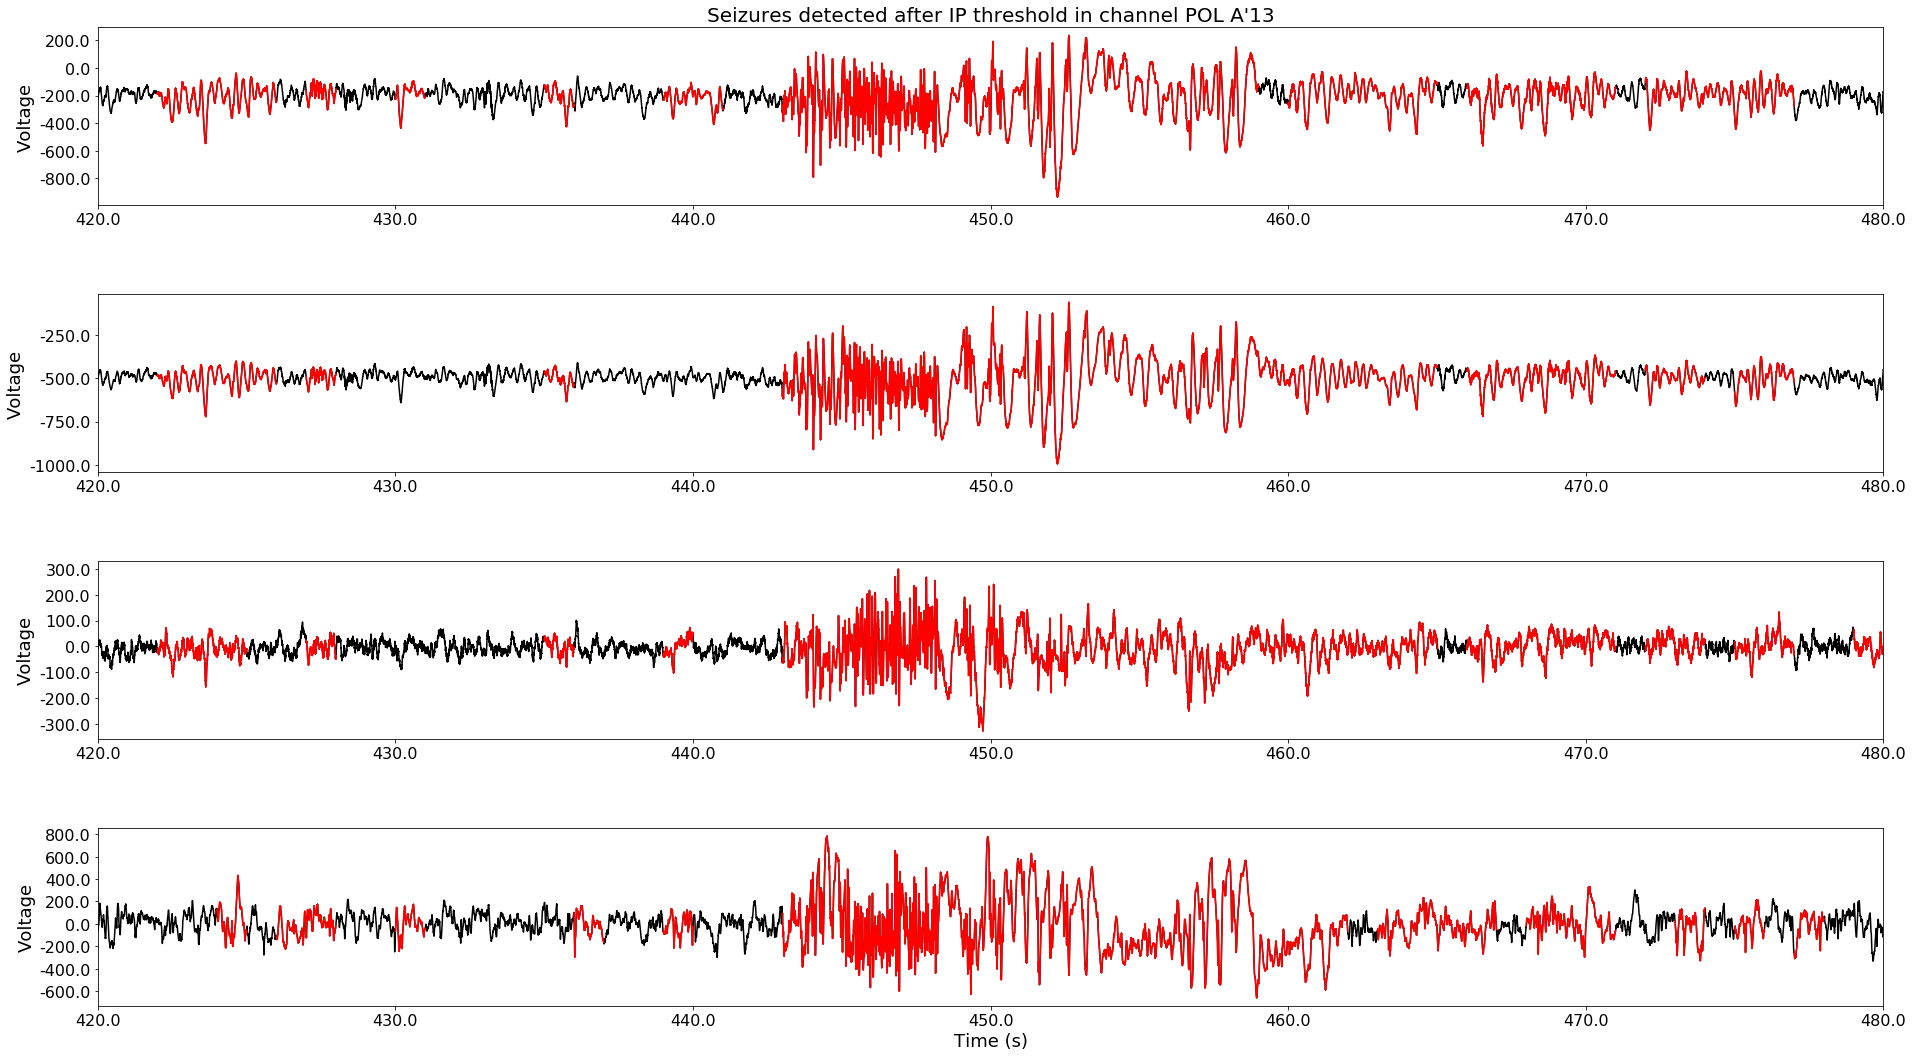

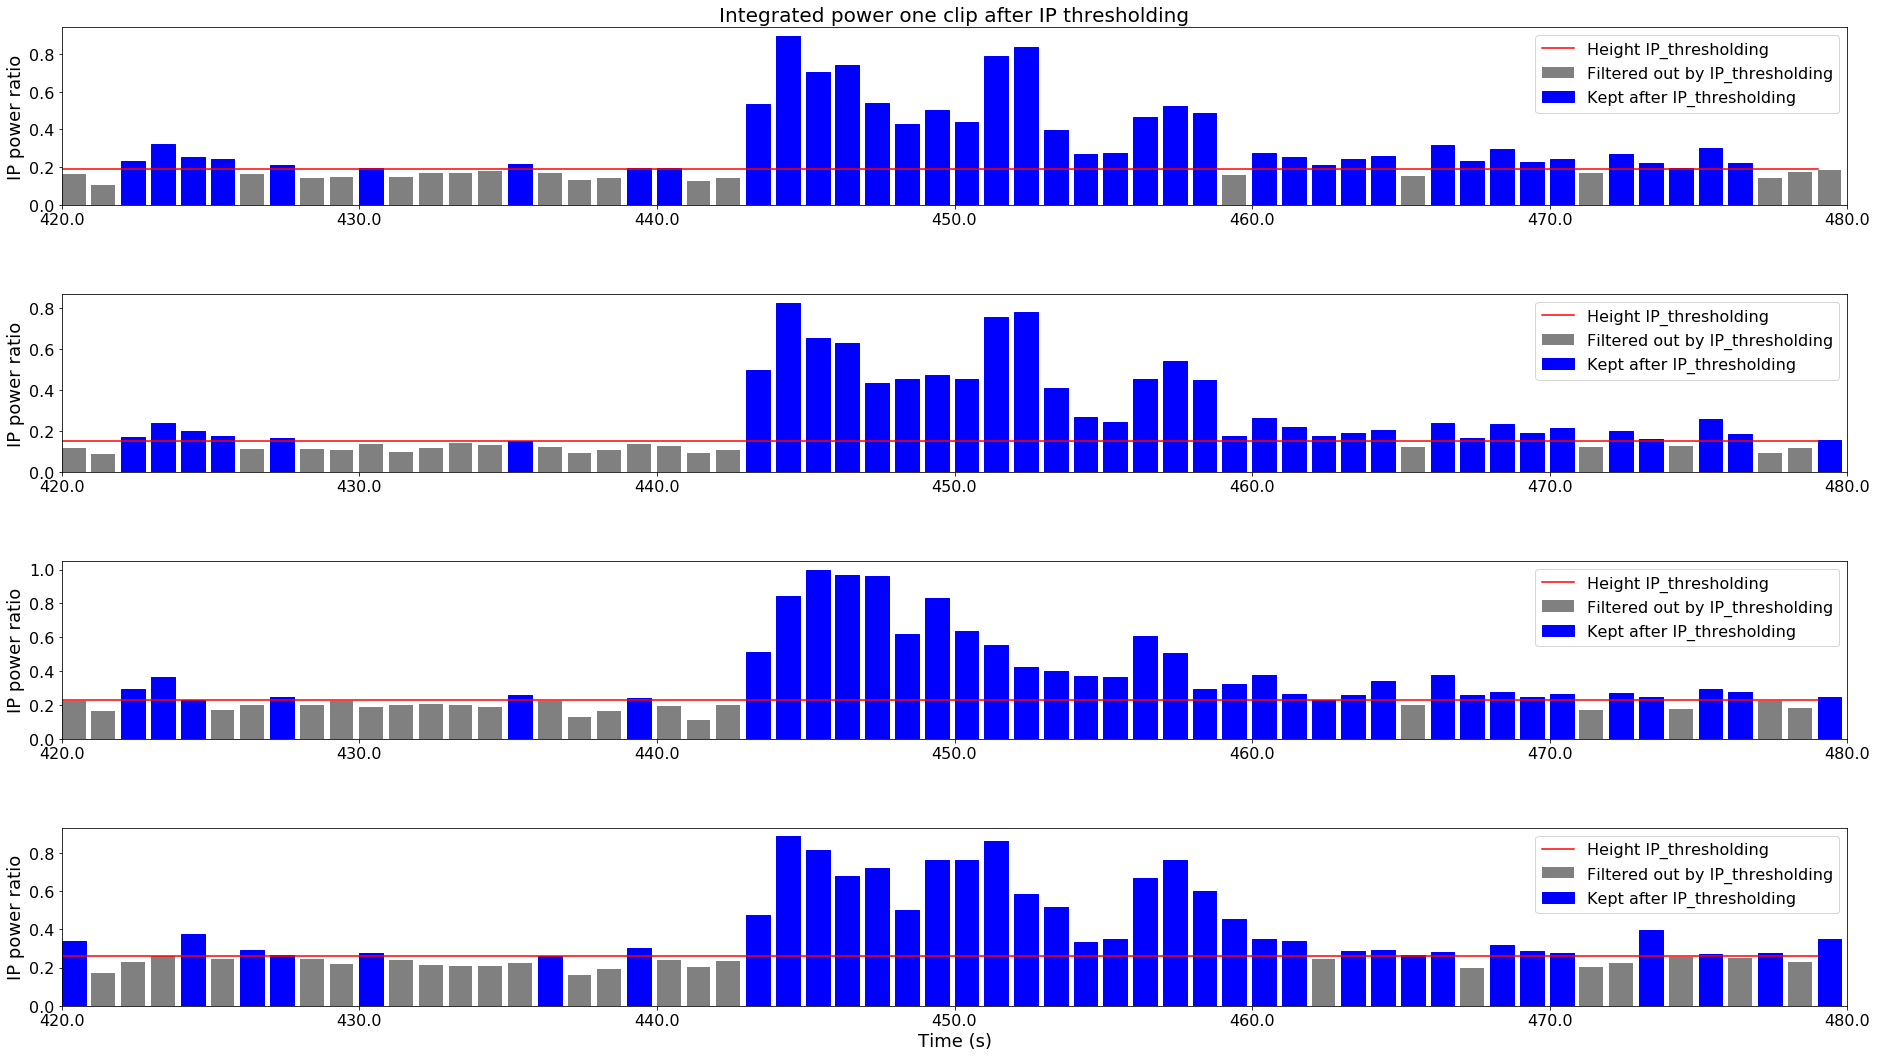

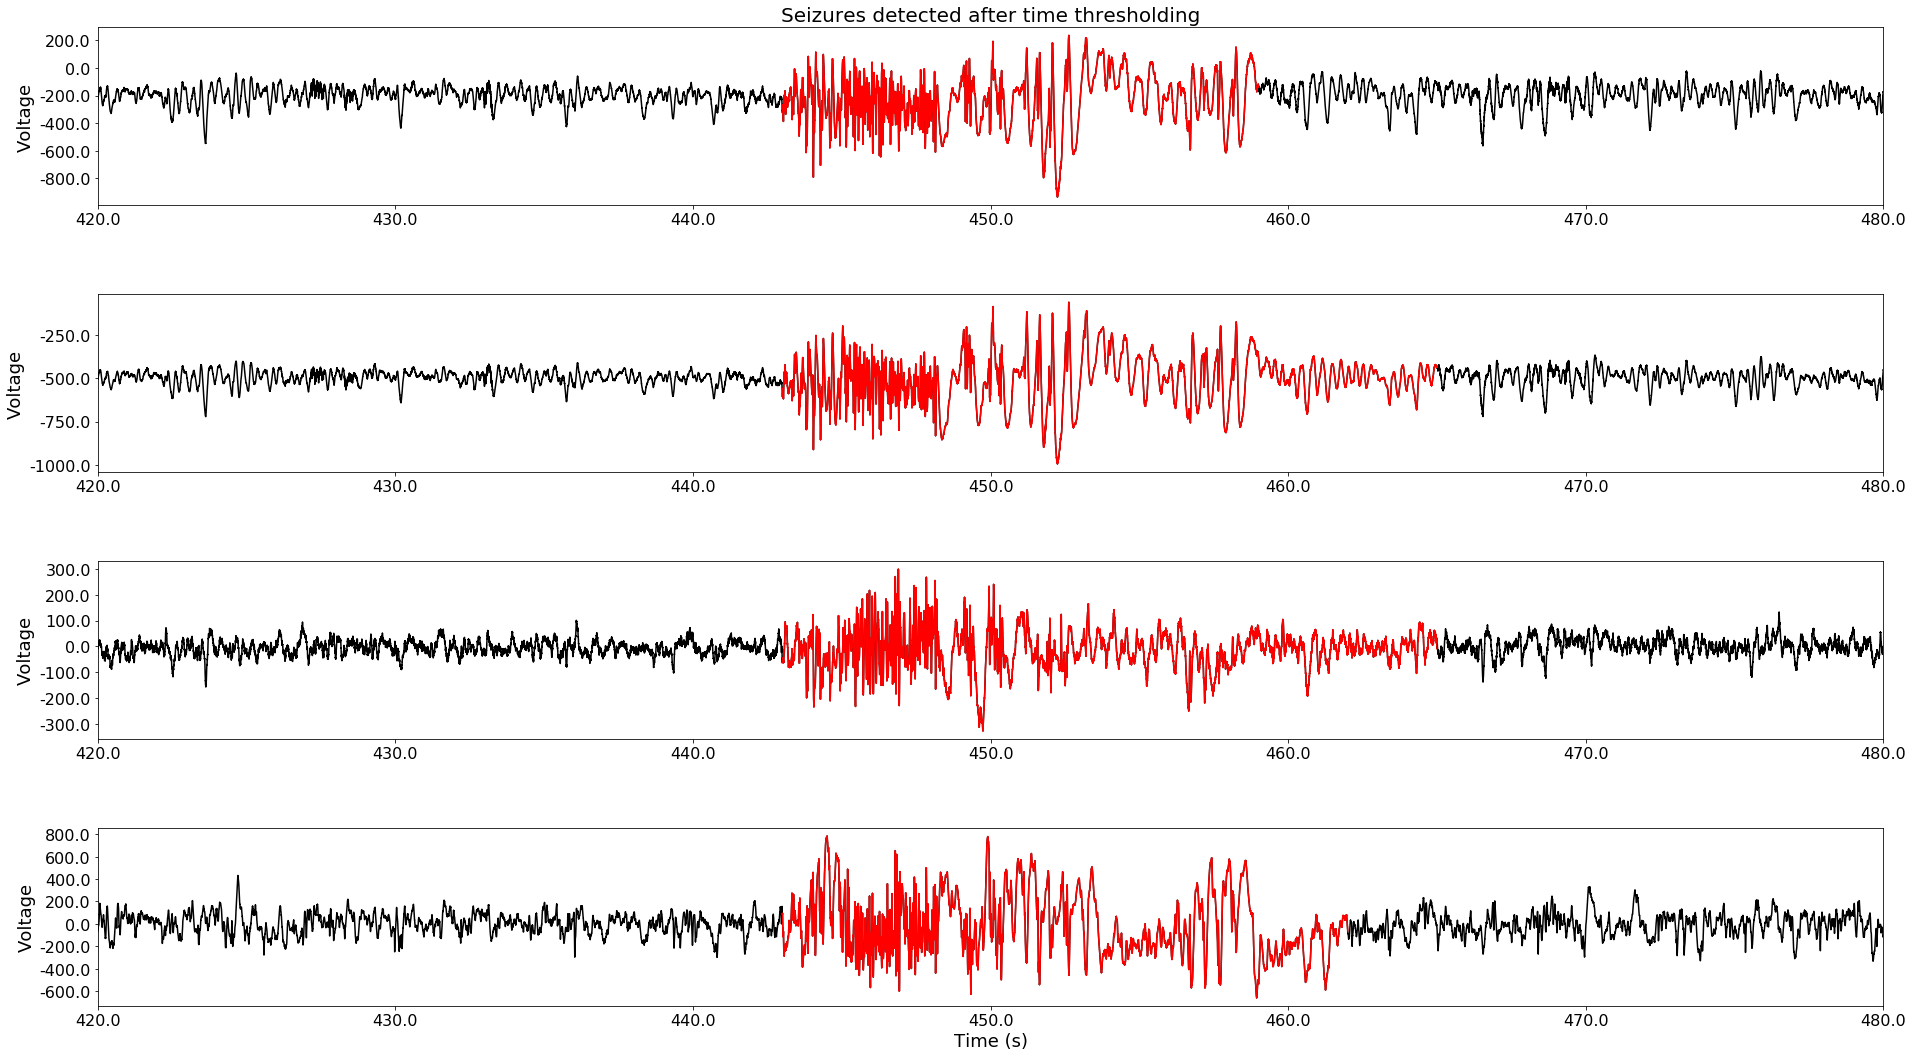

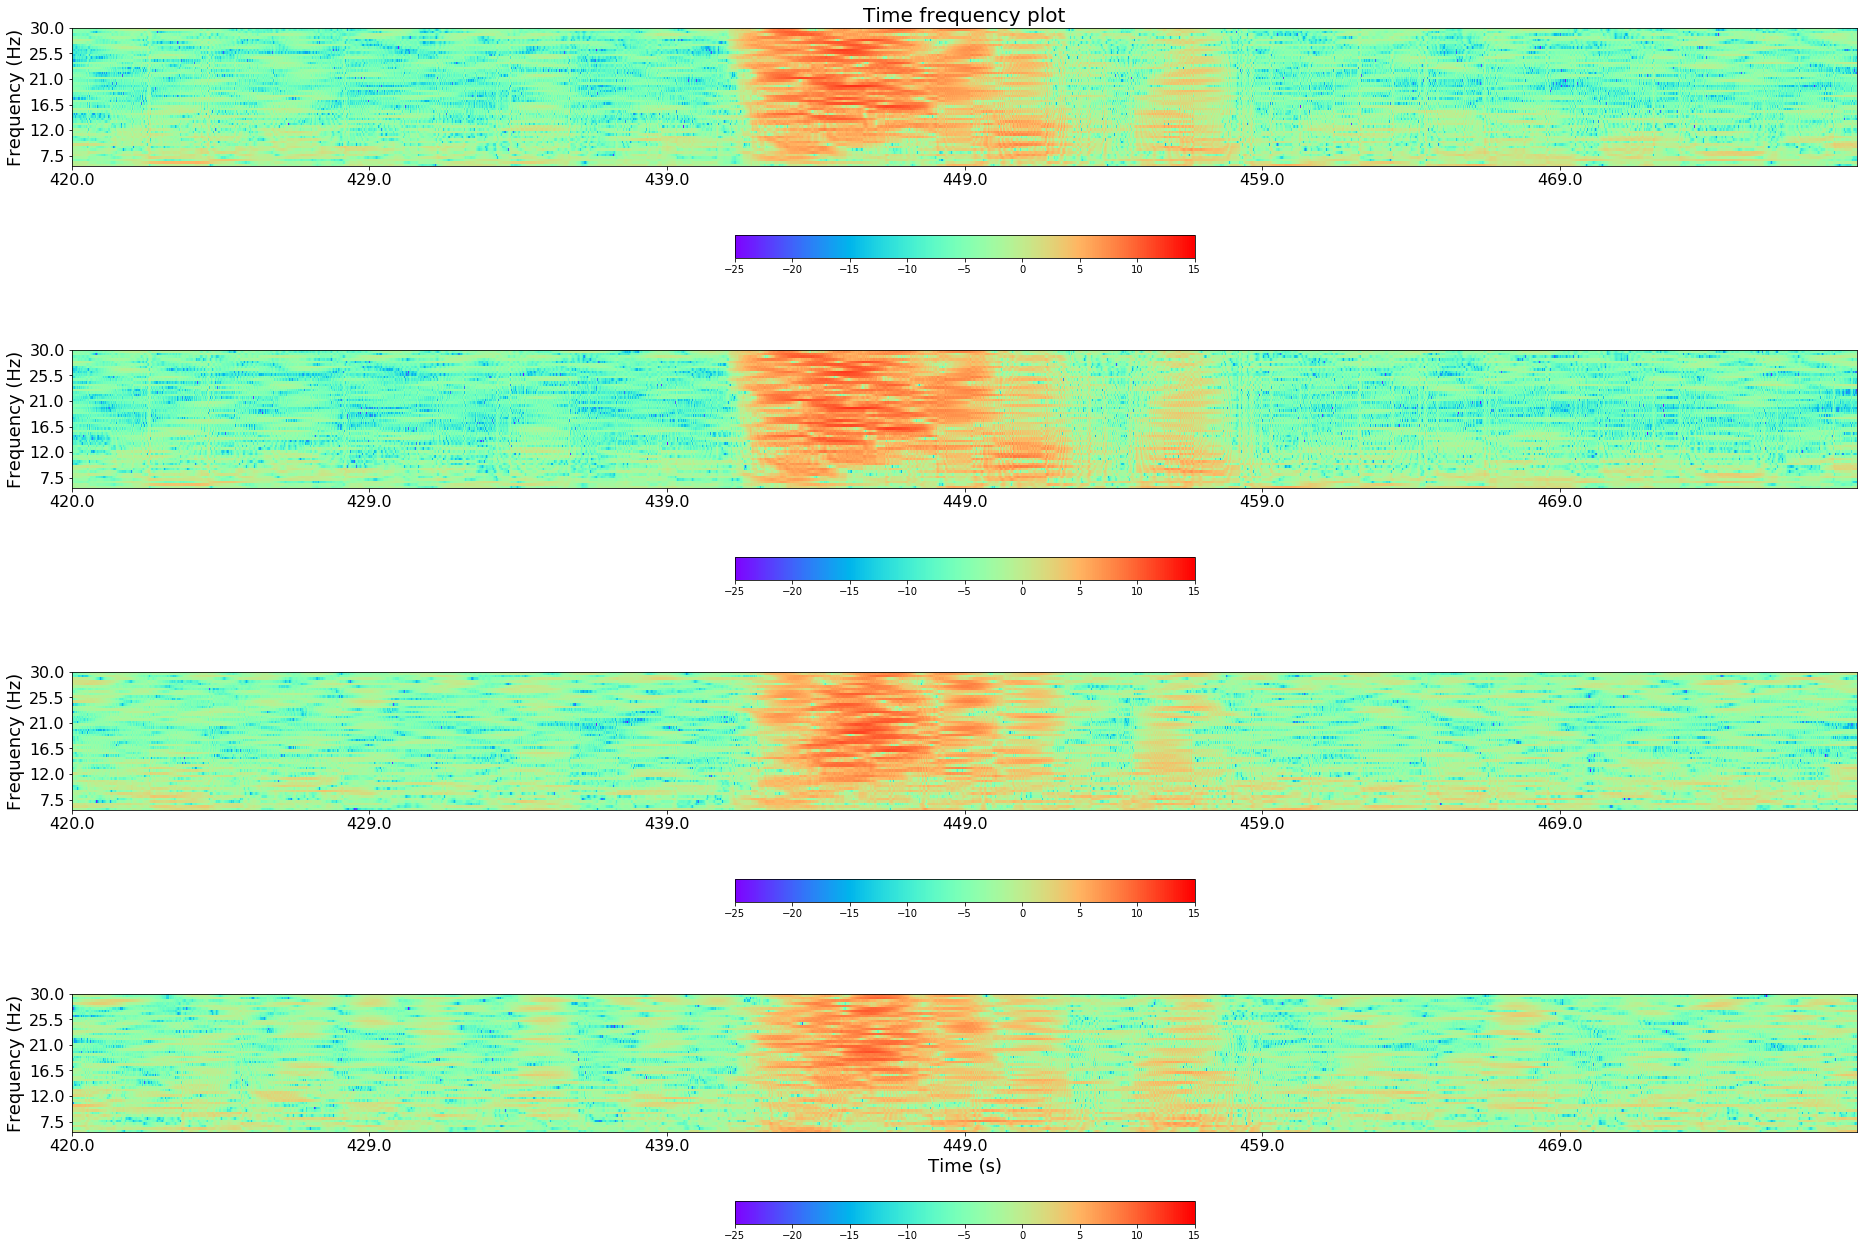

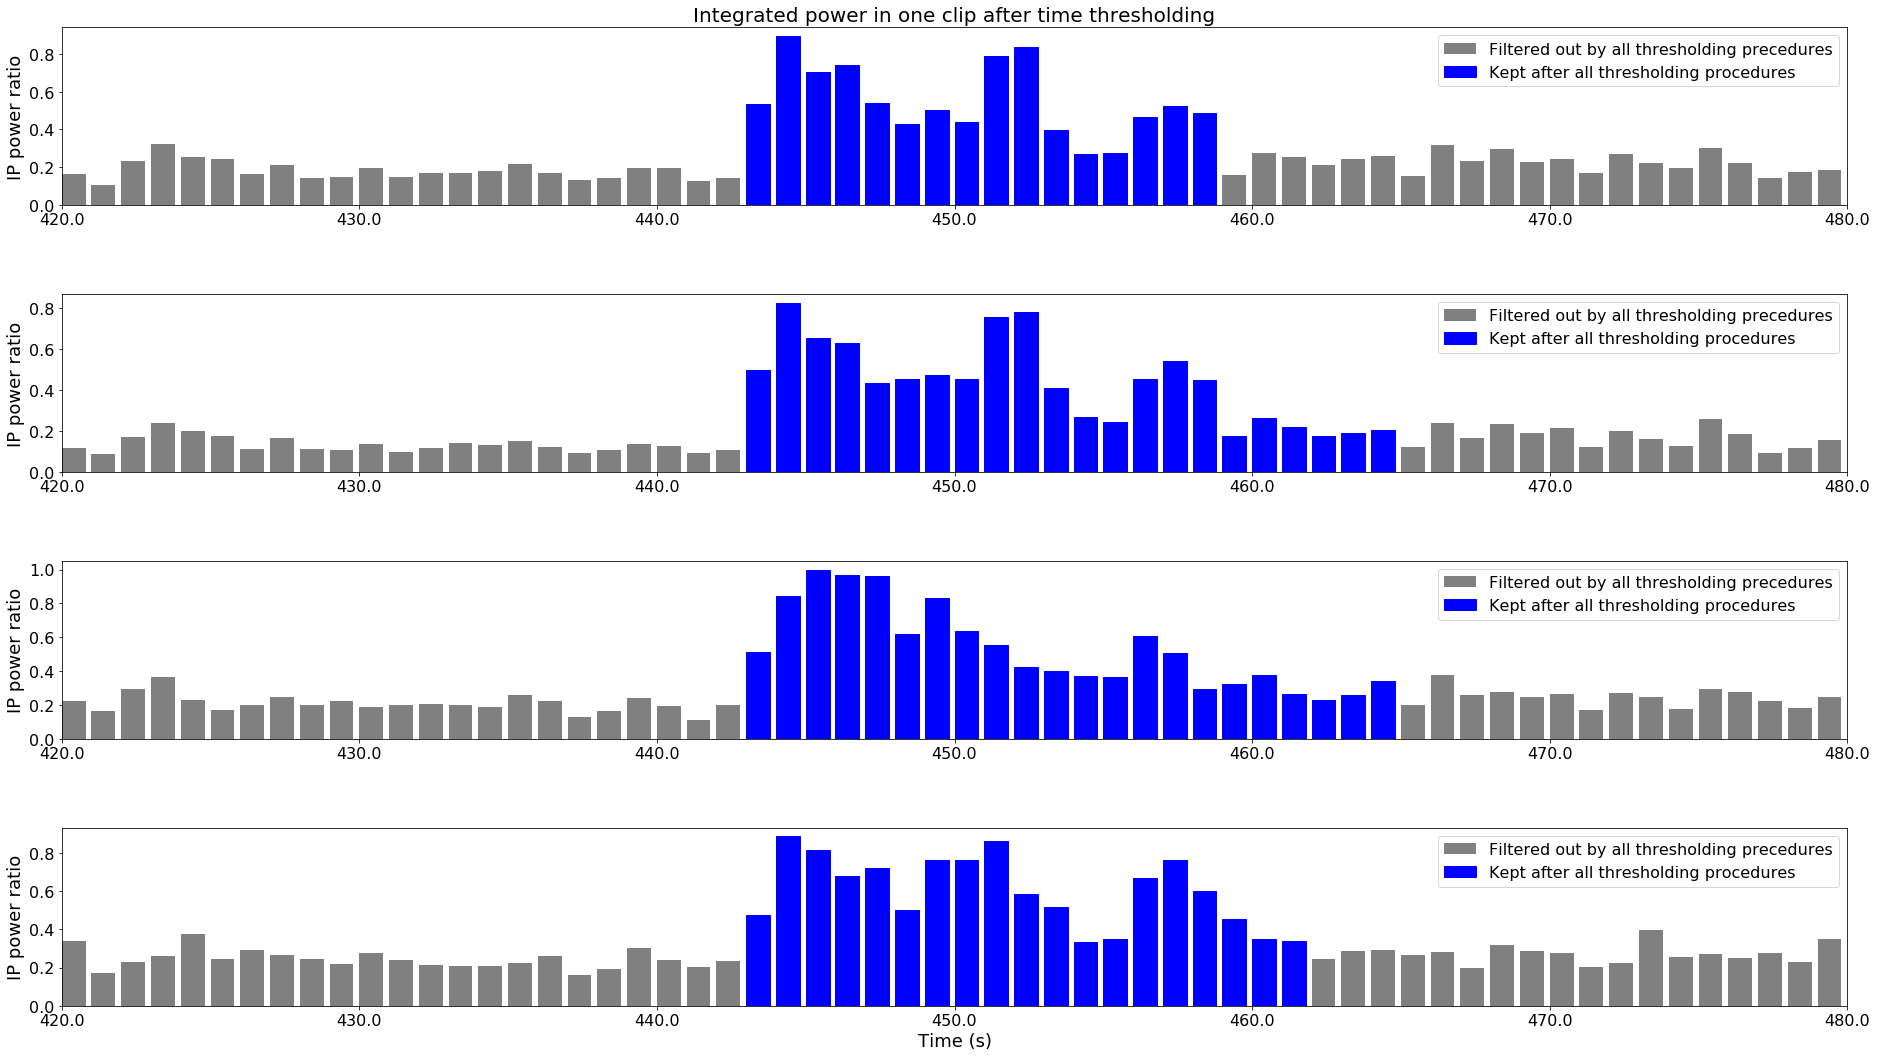

In [11]:
start_time=420
end_time=480
f=(3,30)
wavetime=np.arange(-1,1+1e-08,1/fs)
cycle=[60,100]
num_frex=int((F[1]-F[0])/0.5+1)
cmap='rainbow'

time_start=time.time()
fig_possible,ax_possible=plot_possible(d,Seizure_before,start_time,end_time)
fig_bar_1,ax_bar_1=plot_power_before(IP,start_time,end_time)
fig_seizure,ax_seizure=plot_seizure(d,Seizure_after,start_time,end_time)
fig_tf,ax_tf,power_list,normalized_power_list=plot_heat_map(d,t,f,cycle,num_frex,start_time,end_time)
fig_bar_2,ax_bar_2=plot_power_after(IP,Seizure_after,start_time,end_time)
time_end=time.time()
print('Time spent in plotting is: '+str(np.round(time_end-time_start,2)))

### 4.2 Call functions to plot 2 

In [16]:
def plot_process(IP,Seizure_before,Seizure_after):
    
    num_ch=len(Seizure_before)
    
    fig,ax=plt.subplots(num_ch,1,figsize=(32,18))
    
    for i in range(num_ch):
        Height_sb=[]
        Height_sa=[]
        Rects_sb=[]
        Rects_sa=[]
        Times=[]
        sb=Seizure_before[i]
        sa=Seizure_after[i]
        sb=pd.concat([sb,sa]).drop_duplicates(keep=False)
        sb=sb.reset_index(drop=True) 
        if sb.shape[0]!=0:
            for j in range(sb.shape[0]):
                ind_start=sb.loc[j,'start_clip']
                ind_end=sb.loc[j,'end_clip']
                height=sum(IP[i][ind_start:ind_end+1])/np.max(IP[i])
                Height_sb.append(height)
        else:
            pass
        
        if sa.shape[0]!=0:
            for j in range(sa.shape[0]):
                ind_start=sa.loc[j,'start_clip']
                ind_end=sa.loc[j,'end_clip']
                height=sum(IP[i][ind_start:ind_end+1])/np.max(IP[i])
                Height_sa.append(height)
        else:
            pass
                
        if len(Height_sb)!=0:
            for k in range(len(Height_sb)):
                (x,y)=(sb.loc[k,'start_clip'],0)
                width=sb.loc[k,'end_clip']-sb.loc[k,'start_clip']
                height=Height_sb[k]
                rect=plt.Rectangle((x,y),width,height,edgecolor='gray',facecolor='gray',alpha=0.5)
                ax[i].add_patch(rect)
                Rects_sb.append(rect)
        
        else:
            pass
                
        if len(Height_sa)!=0:
            for k in range(len(Height_sa)):
                (x,y)=(sa.loc[k,'start_clip'],0)
                width=sa.loc[k,'end_clip']-sa.loc[k,'start_clip']
                height=Height_sa[k]
                rect=plt.Rectangle((x,y),width,height,edgecolor='blue',facecolor='blue',alpha=1)
                ax[i].add_patch(rect)
                Rects_sa.append(rect)       
        else:
            pass
        
        if i==num_ch-1:
            ax[i].set_xlabel('Time (s)',fontsize=18)
        else:
            pass
        
        ax[i].set_ylabel('Summation of IP power',fontsize=18)
        if i==0:
            ax[i].set_title('Integrated power during seizure time in channel',size=20)
        else: 
            pass
        
        ax[i].set_xticks(np.linspace(0,n_clip,8))
        ax[i].set_xticklabels(np.floor(np.linspace(0,n_clip,8)),fontsize=16)
        ax[i].set_yticks(np.linspace(0,np.ceil(max(max(Height_sb),max(Height_sa))),6))
        ax[i].set_yticklabels(np.round(np.linspace(0,np.ceil(max(max(Height_sb),max(Height_sa))),6),1),fontsize=16)
        labels=[Rects_sb[0],Rects_sa[0]]
        names=['Filtered out Seizures','Kept Seizures']
        ax[i].legend(labels,names,loc='best',fontsize=16)
        
    plt.subplots_adjust(hspace=0.5)
        
    return fig,ax
    return fig,ax

def plot_all_heat_map(d,t,Seizure_after,f,cycle,num_frex):
    
    num_ch=d.shape[0]
    
    res_list=[]
    Fig=[]
    Ax=[]
    for i in range(0,2): 
        seizure=Seizure_after[i]
        d_period=d[i,:]
        t_period=t[0,:]
        frex=np.linspace(f[0],f[1],num_frex)
        range_cycles=np.linspace(cycle[0],cycle[1],num_frex)
        Sigma=range_cycles/(2*np.pi*frex)
        res_list_ch=[]
        print('Begin to process and visualize channel '+str(ch_names[i]))
        fig,ax=plt.subplots(seizure.shape[0],2,figsize=(40,18))
        for j in range(seizure.shape[0]):
            old_start_time=seizure.loc[j,'start_clip']
            old_start_ind=int(fs*old_start_time)
            old_end_time=seizure.loc[j,'end_clip']
            old_end_ind=int(fs*old_end_time)
            middle=(old_start_time+old_end_time)/2
            start_time=old_start_time-5
            start_ind=int(fs*start_time)
            end_time=old_end_time+5
            end_ind=int(fs*end_time)
            eeg=d_period[start_ind:end_ind,]
            t_vec=t_period[start_ind:end_ind,] 
            ndata=len(eeg)
            nwin=len(wavetime)
            eeg_flip=np.flip(eeg)
            eeg=np.concatenate((eeg_flip,eeg,eeg_flip))
            nconv=3*ndata+nwin-1
            half_wave=int((2*ndata+len(wavetime)-1)/2)
            eeg_AK=np.fft.fft(eeg,nconv)
            res=np.zeros((len(frex),len(t_vec)),dtype=np.float32) # from small(large) to large(bottom)
            for k in range(len(frex)):
                wave_AK=DFT_wavelet(frex[k],wavetime,Sigma[k],nconv)
                r=np.fft.ifft(eeg_AK*wave_AK)
                r=r[half_wave:-half_wave]
                res[k,:]=np.abs(r)
                
            res_list_ch.append(res)
            
            ax[j,0].plot(t_vec,d_period[start_ind:end_ind,],'black') # original part in black
            ax[j,0].plot(t_period[old_start_ind:old_end_ind,],d_period[old_start_ind:old_end_ind],'red')
            if j==seizure.shape[0]-1:
                ax[j,0].set_xlabel('Time (s)',fontsize=18)
            else:
                pass
            
            ax[j,0].set_ylabel('Amplitude (mV)',fontsize=18)
            if j==0:
                ax[j,0].set_title('The raw plot of seizure period in channel '+ch_names[i],size=20)
            else:
                pass
            
            xticks=ax[j,0].get_xticks()
            xticks=ax[j,0].set_xticks(np.round(np.linspace(np.round(start_ind/fs),np.ceil(end_ind/fs),len(xticks)),1))
            ax[j,0].set_xticklabels(ax[j,0].get_xticks(),fontsize=16)
            ax[j,0].set_xlim(np.floor(start_ind/fs),np.ceil(end_ind/fs))
            yticks=ax[j,0].get_yticks()
            ax[j,0].set_yticklabels(yticks,fontsize=16)
            
            [X,Y]=np.meshgrid(t_vec,frex)
            C=ax[j,1].pcolor(X,Y,Normalization(res,'DB'),cmap=cmap,vmin=-25,vmax=10)
            if j==seizure.shape[0]-1:
                ax[j,1].set_xlabel('Time (s)',fontsize=18)
            else:
                pass
            
            ax[j,1].set_ylabel('Frequency (Hz)',fontsize=18)
            if j==0:
                ax[j,1].set_title('The tf plot of seizure period in channel '+ch_names[i],size=20)
            else:
                pass
            
            ax[j,1].set_xticks(np.round(np.linspace(np.min(t_vec),np.max(t_vec),len(xticks)),1))
            ax[j,1].set_xticklabels(ax[j,1].get_xticks(),fontsize=16)
            yticks=ax[j,1].get_yticks()
            ax[j,1].set_yticklabels(np.round(np.linspace(f[0],f[1],len(yticks)),1),fontsize=16)
            ax[j,1].axvline(x=old_start_time,color='black') 
            ax[j,1].axvline(x=old_end_time,color='black') 
            fig.colorbar(C,ax=ax[j,1],orientation='vertical',fraction=0.01)
            
        plt.subplots_adjust(hspace=0.5)
        
        res_list.append(res_list_ch)
        Fig.append(fig)
        Ax.append(ax)
        
    return Fig,Ax,res_list

Begin to process and visualize channel POL A'13
Begin to process and visualize channel POL A'15
Time spent in plotting is: 345.64


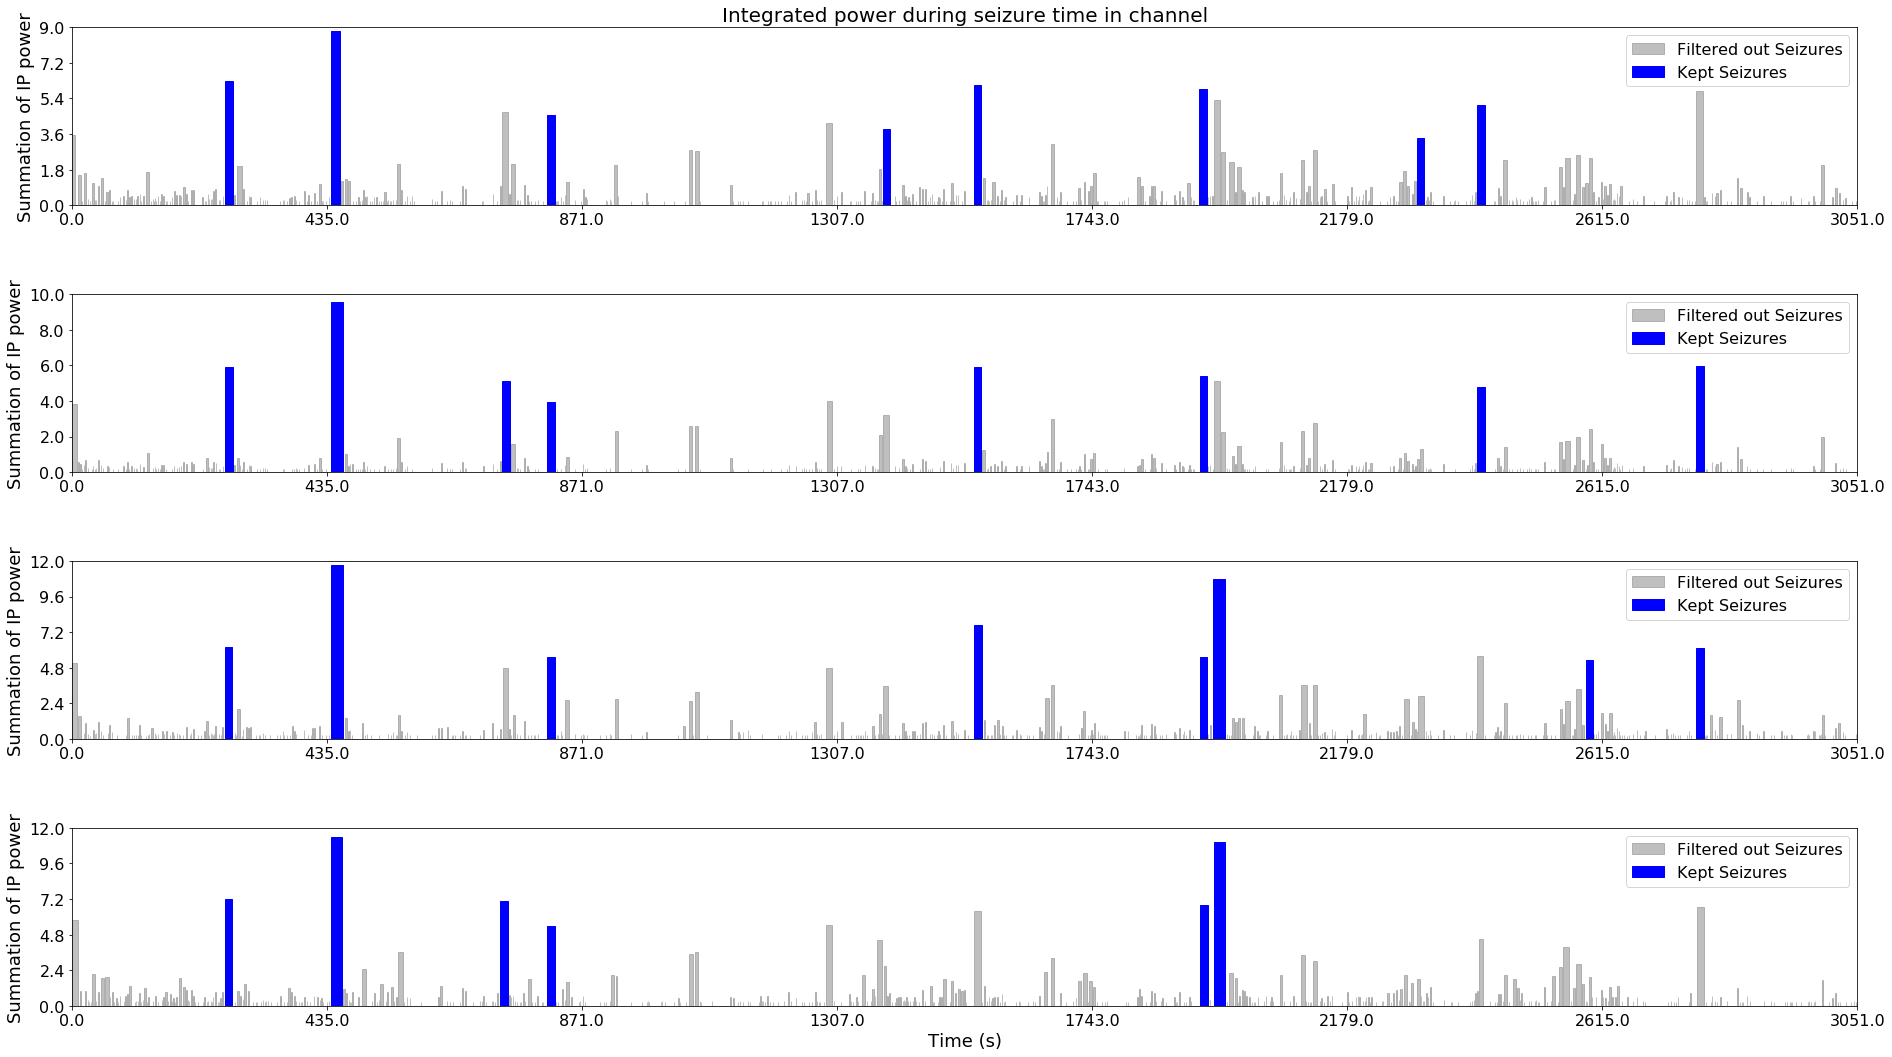

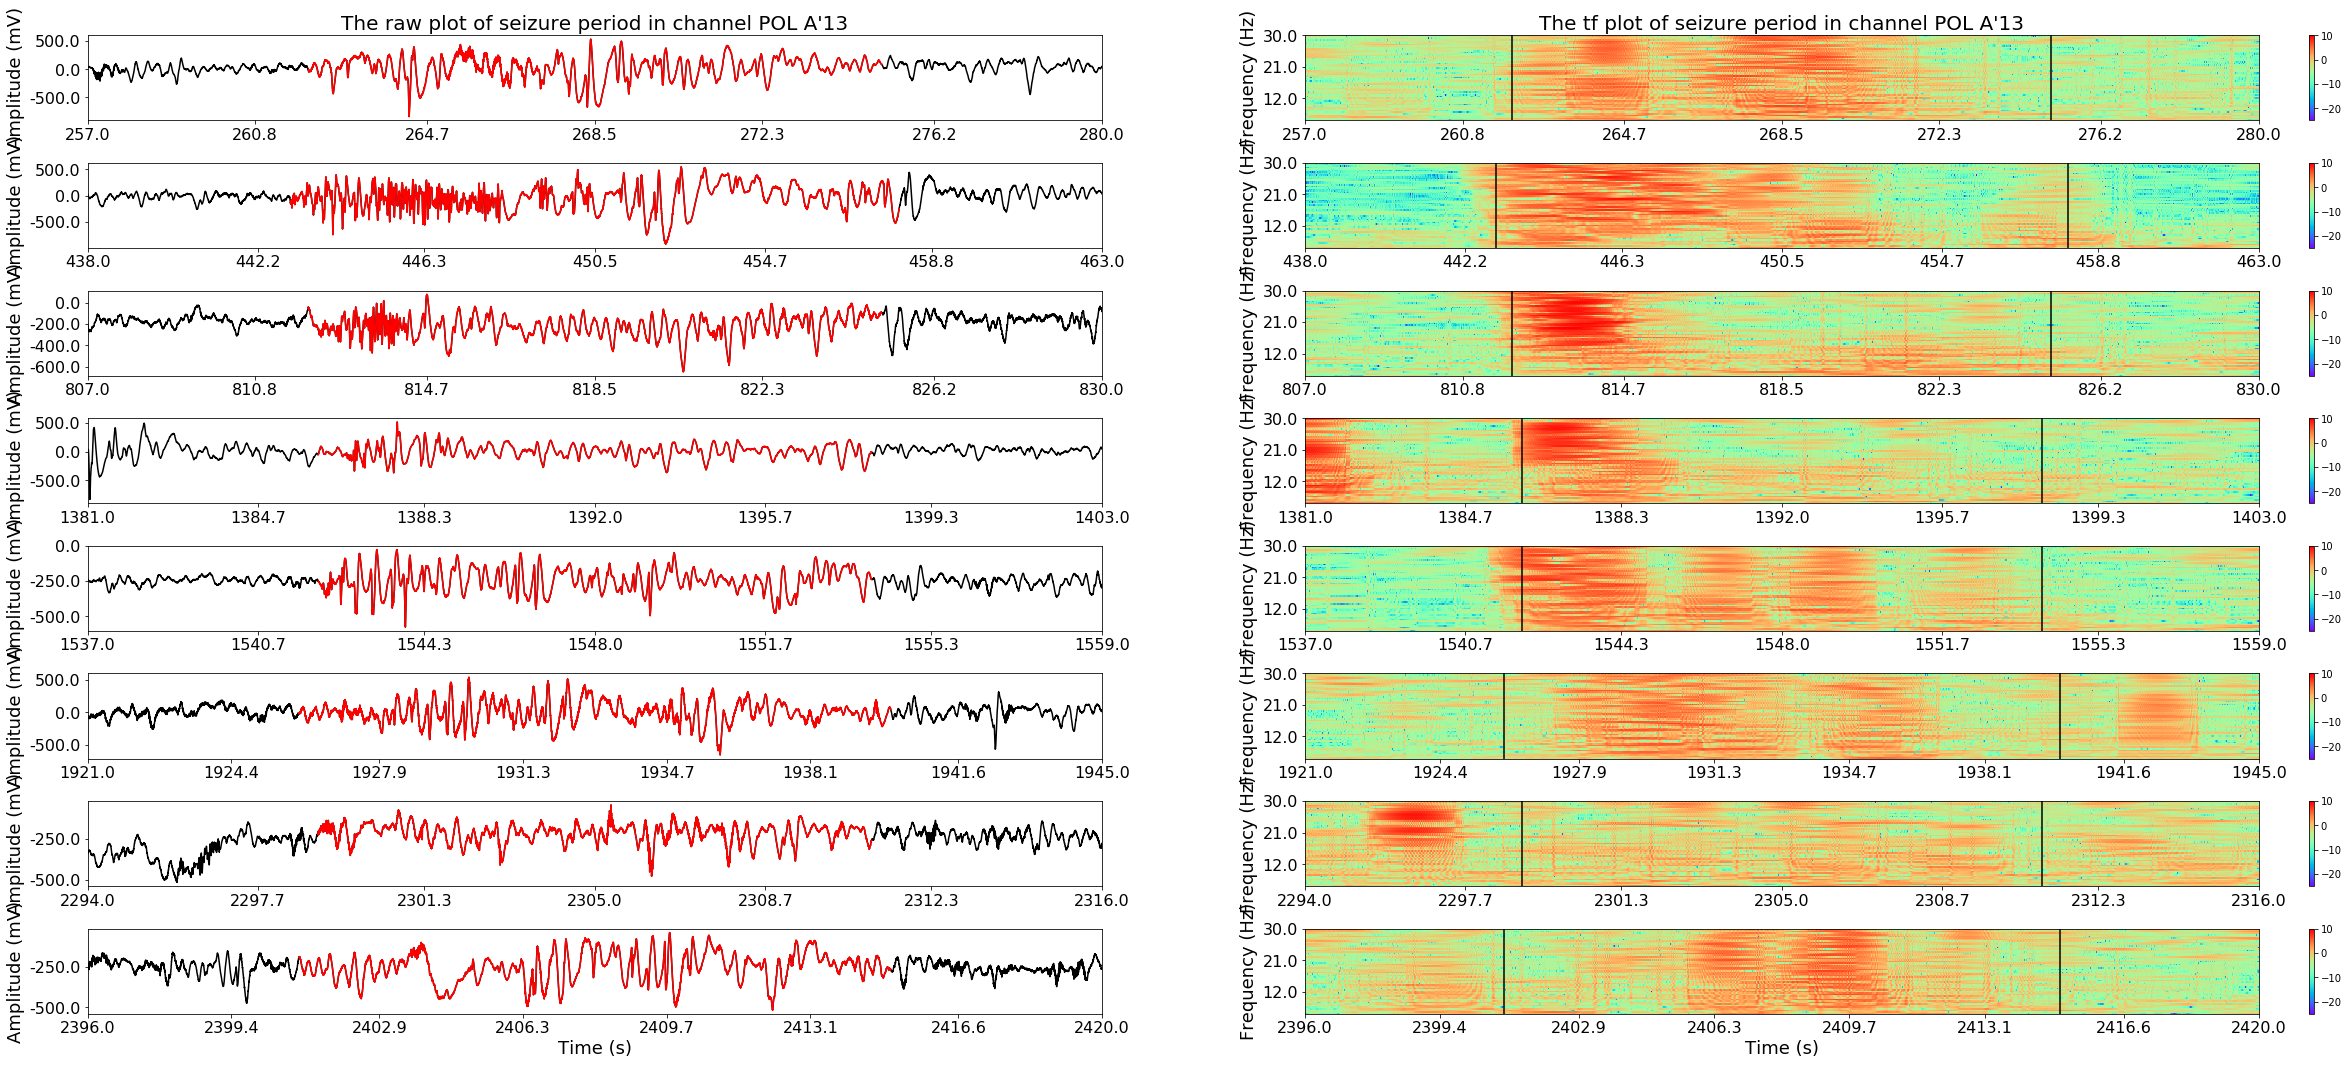

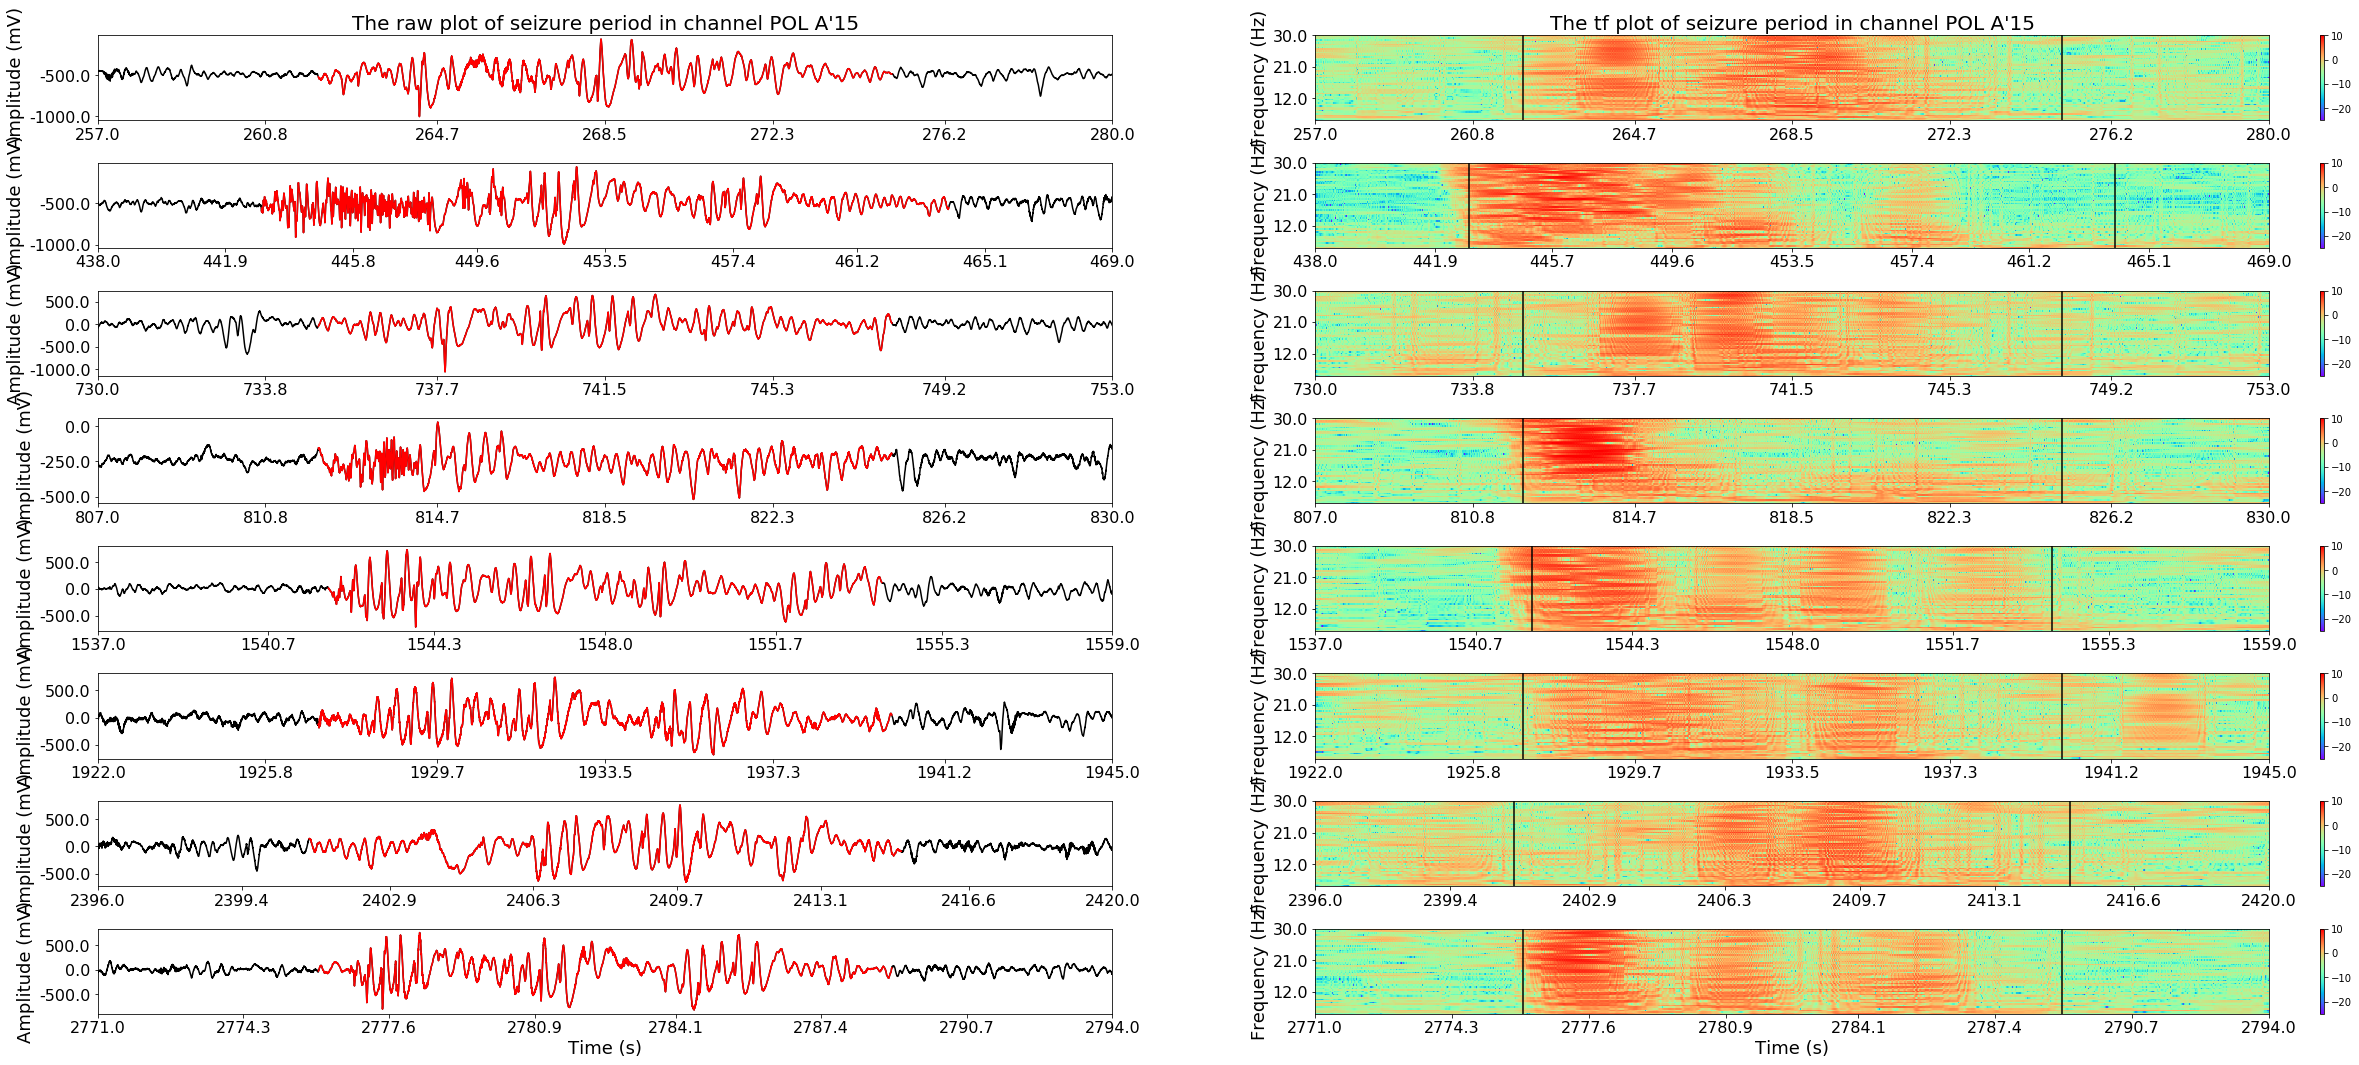

In [17]:
f=(3,30)
wavetime=np.arange(-1,1+1e-08,1/fs)
cycle=[60,100]
num_frex=int((F[1]-F[0])/0.5+1)
cmap='rainbow'

time_start=time.time()
fig_process,ax_process=plot_process(IP,Seizure_before,Seizure_after)
Fig,Ax,res_list=plot_all_heat_map(d,t,Seizure_after,f,cycle,num_frex)
time_end=time.time()
print('Time spent in plotting is: '+str(np.round(time_end-time_start,2)))